# Analysing the Cosmic Microwave Background (CMB) data of the Planck space observatory

The main goal for the mission of the Planck space observatory was to gather data of the CMB radiation more detailed than ever before. During the timeframe of the mission, several data dumps were released to the scientfic public. All of them can be still currently reached freely by anyone from the IRSA project's [data dump](https://irsa.ipac.caltech.edu/data/Planck/). In this directory we can find the data from all 3 data releases in [2013](https://irsa.ipac.caltech.edu/data/Planck/release_1/), [2016](https://irsa.ipac.caltech.edu/data/Planck/release_2/) and [2020](https://irsa.ipac.caltech.edu/data/Planck/release_3/).

During the analytic section of this project I worked with the data available here. Under the `/release_*/all_sky_map/` pages we can find several different iteration and filterings of the CMB data, grouped by time, frequency ranges of instruments, filtering types, producing pipelines, etc. There are also intensivity and polarization maps attached to each entry in each categories, alongside numerous other type of datasets.

In [1]:
import os
import sys
import numpy as np
import healpy as hp
from functools import partial
import astropy.io.fits as fits

import reconcmb as cmb

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data = './data/'
out = './output/'

### Just some matplotlib and seaborn parameter tuning

In [3]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Load and visualize a Planck map from a `.fits` dump

The most important file is the latest release of the pure CMB map from one of the procession pipelines. I've used data of the *Commander* pipeline, where the corresponding file can be downloaded from [here](https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander_2048_R3.00_full.fits) in a `HEALPix FITS` format. This file consist of 8 fields, where the `I_STOKES_INP` one contains the final Planck CMB temperature fluctuation map.

In [4]:
os.listdir(data)

['COM_CMB_IQU-commander_2048_R3.00_full.fits',
 'CAMB_fiducial_cosmo_scalCls.dat',
 'Planck_Parchment_RGB.txt']

In [5]:
file = data + 'COM_CMB_IQU-commander_2048_R3.00_full.fits'
# Currently throws two warnings, but it's completely normal behavior
#   - Warning to explicitly specify dtype in the future (here it is specified, but still throws warning)
#   - Warning for missing INDXSCHM keyword in the fits header (that's the inherent problem of the dataset,
#     deal with it)
#
# FIELD=5 is the INP Intensity map, which is the fully processed CMB temp. anisotropy map
hpx, hpx_muK, header = cmb.load_HPX(file, field=5)
# Calculate the N_SIDE, HEALPix parameter
N_SIDE = int(np.sqrt(hpx.shape[0] / 12))

/home/masterdesky/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/masterdesky/miniconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [6]:
header;

In [7]:
hpx_proj = cmb.get_projection(hpx_muK, proj='moll', N_SIDE=N_SIDE)

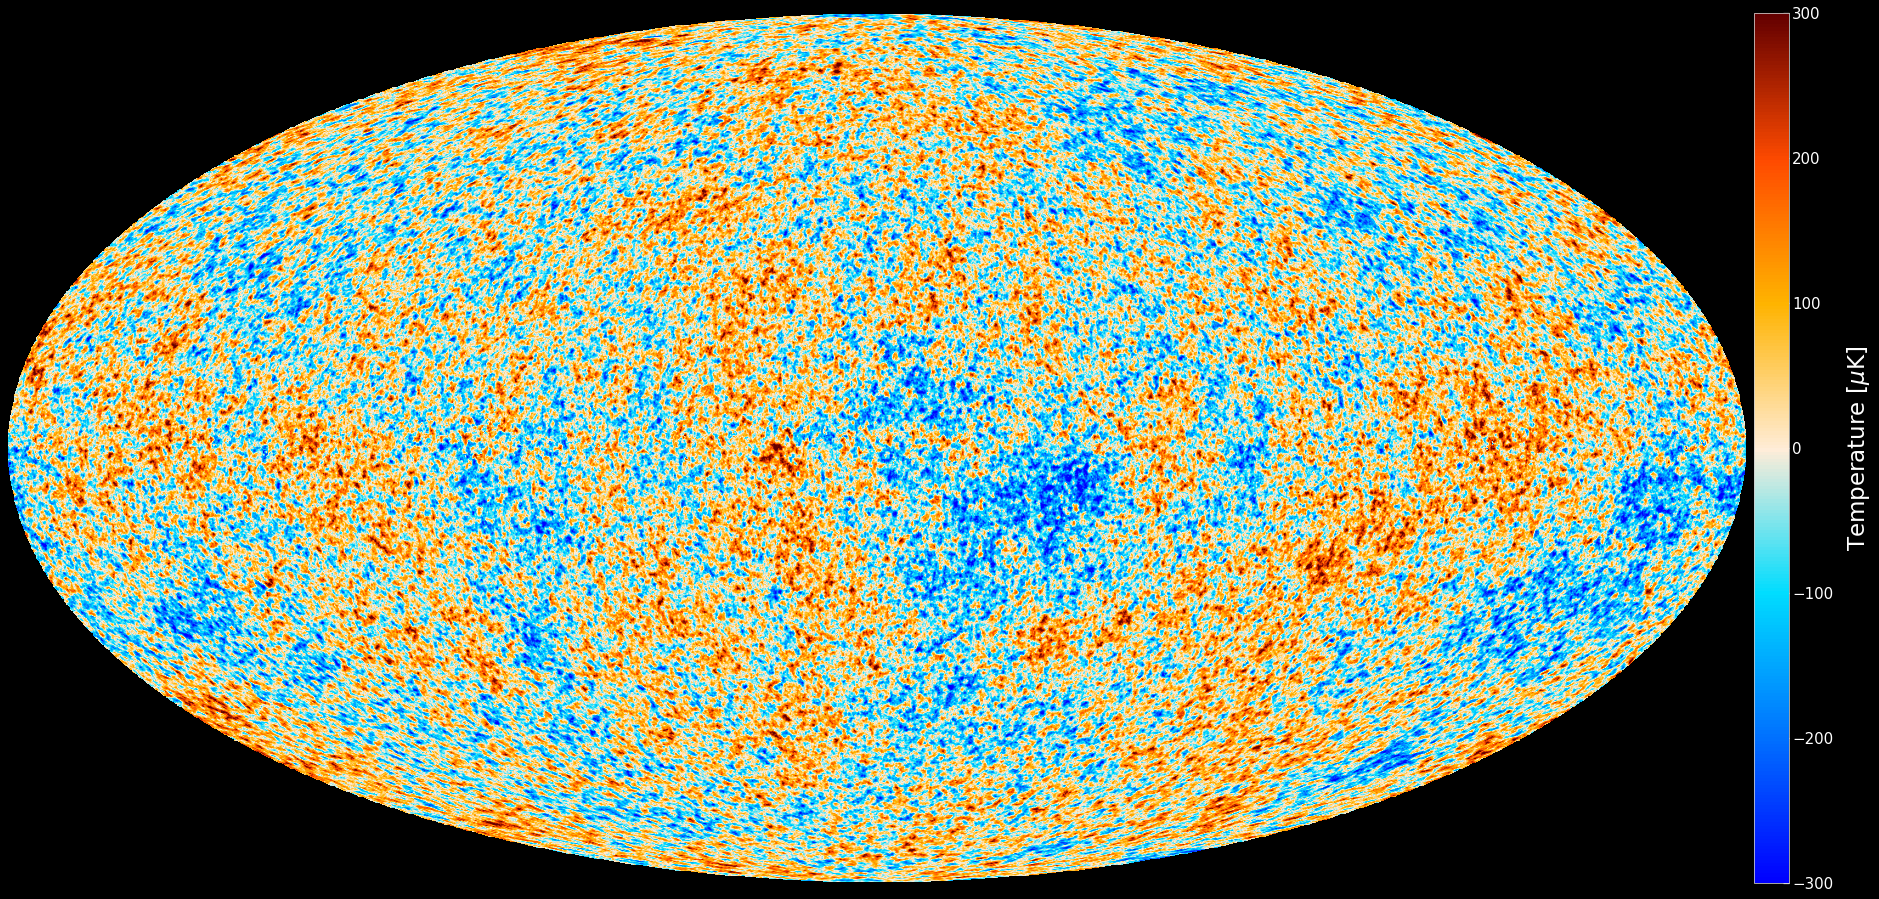

In [8]:
cmb.plot_cmb(proj=hpx_proj, cmap=None, c_min=-300, c_max=300,
             save=False, save_filename='cmb_map_planck_2018')

## 2. Calculate power spectrum with `anafast`

The `anafast` estimator is built in Fortran90, which was included in the HEALPix library too.

In [9]:
lmax = 2500
ell, Cl, alm = cmb.cmb_spectrum(hpx_muK, lmax=lmax, alm=True)
Dl = ell * (ell + 1) / (2*np.pi) * Cl

In [10]:
# Read in the input CMB spectra
inp_spec = np.genfromtxt(data + 'CAMB_fiducial_cosmo_scalCls.dat')
DlTT = inp_spec[:,1][:lmax+1]

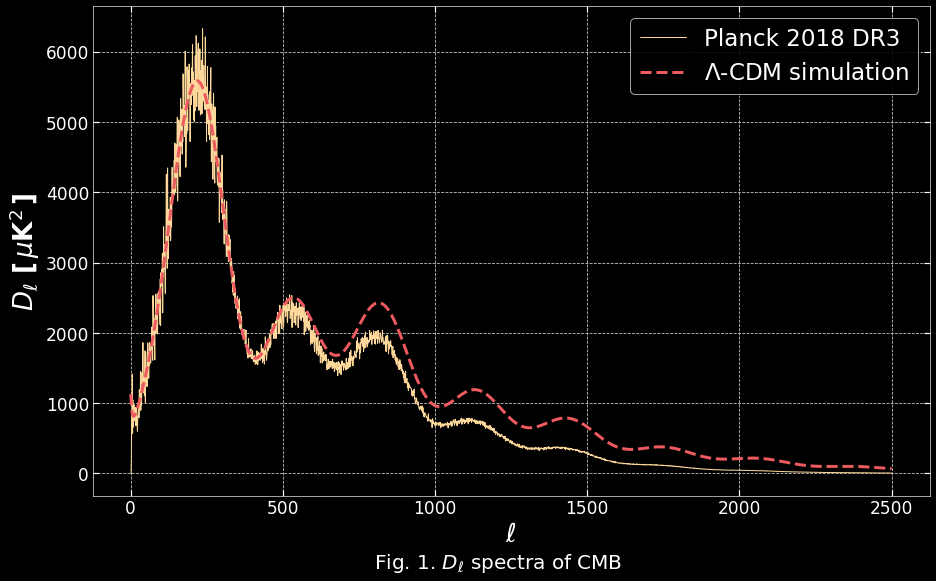

In [11]:
cmb.plot_spectrum(ell, Dl, DlTT,
                  save=True, save_filename='cmb_angular_spectrum_planck_2018')